In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)
from sklearn.naive_bayes import (GaussianNB, MultinomialNB)
import re 
import nltk

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
nltk.download('stopwords')
#Analisis de texto clasico ciertas palabras no añaden contexto y en base al resto de palabras podemos entender las relaciones.
# funcion para quitar los stopwords del dataframe 

def remove_stopwords(text):
    clean_text = []
    text = text.lower()
    if text is not None:
        words = text.split()
        for word in words:
            if word not in stop_words:
                clean_text.append(word)
        return ' '.join(clean_text)
    else:
        return None

def remove_symbols(text):
      if text is not None:
          text = re.sub(r'''[.,?*&'"+${}-]''','',text)
          return text
      else:
          return None



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html

df_raw = pd.read_csv('trump_tweets.csv')
nrc = pd.read_csv('NRC.csv', names=['word', 'sentiment', 'polarity'])
nrc = nrc.query('polarity==1')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [4]:
df_raw.sample(10, random_state=2024)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
18829,Twitter for iPhone,928861178113040385,"Just landed in Da Nang, Vietnam to deliver a s...",2017-11-10T05:45:36Z,7819,NaN,51886,False
2573,Twitter Web Client,245962060964454400,"It's Wednesday, how many more of our embassies...",2012-09-12T19:08:19Z,172,NaN,22,False
14681,Twitter Web Client,568863185488510976,Entrepreneurs: Identify your goals. Know preci...,2015-02-20T20:02:07Z,283,NaN,340,False
4408,Twitter for Android,406733362720940032,Offshore Wind in Europe: Lessons for the U.S. ...,2013-11-30T10:36:05Z,23,NaN,21,False
3678,TwitLonger Beta,186858054782947328,The US should not give a penny of foreign aid ...,2012-04-02T16:50:06Z,186,NaN,17,False
18480,Twitter for Android,683712803392323584,".@chucktodd said today on @meetthepress that ""...",2016-01-03T18:13:29Z,1343,NaN,3861,False
4650,Twitter Web Client,397831685498089473,Sen. @DavidVitter &amp; @David_Bossie w/@sean...,2013-11-05T21:03:59Z,64,NaN,19,False
16513,Twitter Web Client,756308357804335106,You can watch 360 video live from the podium! ...,2016-07-22T02:02:18Z,3750,NaN,12875,False
3942,Twitter Web Client,167698041216839680,The Church is yet another victim to his libera...,2012-02-09T19:55:03Z,132,NaN,19,False
19887,Twitter for iPhone,878019881353871360,I am very supportive of the Senate #Healthcare...,2017-06-22T22:40:27Z,11200,NaN,55678,False


In [5]:
# que dispositivo usa 
# Palabras mas comunes 

df_interim = df_raw.copy()

In [6]:
df_interim = df_interim.drop(['id_str', 'is_retweet', 'in_reply_to_user_id_str'], axis=1)

In [7]:
df_interim['created_at'] = pd.to_datetime(df_interim['created_at'])
df_interim['source'] = pd.Categorical(df_interim['source'])
df_interim

,source,text,created_at,retweet_count,favorite_count
0,Twitter Web Client,From Donald Trump: Wishing everyone a wonderfu...,2009-12-23 17:38:18+00:00,28,12
1,Twitter Web Client,Trump International Tower in Chicago ranked 6t...,2009-12-03 19:39:09+00:00,33,6
2,Twitter Web Client,Wishing you and yours a very Happy and Bountif...,2009-11-26 19:55:38+00:00,13,11
3,Twitter Web Client,Donald Trump Partners with TV1 on New Reality ...,2009-11-16 21:06:10+00:00,5,3
4,Twitter Web Client,"--Work has begun, ahead of schedule, to build ...",2009-11-02 14:57:56+00:00,7,6
...,...,...,...,...,...
20756,Twitter for Android,Various media outlets and pundits say that I t...,2017-01-02 18:37:10+00:00,9057,47285
20757,Twitter for Android,"@CNN just released a book called ""Unprecedente...",2017-01-02 18:32:29+00:00,3948,13862
20758,Twitter for Android,"Chicago murder rate is record setting - 4,331 ...",2017-01-02 17:31:17+00:00,17411,63340
20759,Twitter for Android,"Well, the New Year begins. We will, together, ...",2017-01-02 14:40:10+00:00,29248,124024


In [8]:
df_interim.loc[(df_interim["created_at"]>="2015-06-17")&(df_interim["created_at"]<="2016-11-08")]

,source,text,created_at,retweet_count,favorite_count
12072,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 23:21:49+00:00,6776,16495
12073,Twitter for Android,"Do you believe that The State Department, on N...",2015-12-31 23:11:35+00:00,2755,6824
12074,Twitter for iPhone,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 18:51:12+00:00,2468,6047
12075,Twitter for iPhone,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 16:52:38+00:00,2080,8416
12076,Twitter for Android,I would feel sorry for @JebBush and how badly ...,2015-12-31 15:07:18+00:00,1875,5780
...,...,...,...,...,...
18502,Twitter for Android,"Well, the year has officially begun. I have ma...",2016-01-01 23:00:09+00:00,2642,8495
18503,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,2016-01-01 06:07:28+00:00,1948,8258
18504,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,2016-01-01 05:18:23+00:00,3434,9143
18505,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,2016-01-01 03:25:27+00:00,3460,8581


In [9]:
# Filtrar desde el inicio hasta las elecciones(Creo xD)
df_interim = df_interim.loc[(df_interim["created_at"]>="2015-06-17")&(df_interim["created_at"]<="2016-11-08")]
df_interim["created_at"]+=pd.Timedelta(-5,unit="h")
df_interim

/tmp/ipykernel_7908/659087104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interim["created_at"]+=pd.Timedelta(-5,unit="h")


,source,text,created_at,retweet_count,favorite_count
12072,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 18:21:49+00:00,6776,16495
12073,Twitter for Android,"Do you believe that The State Department, on N...",2015-12-31 18:11:35+00:00,2755,6824
12074,Twitter for iPhone,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 13:51:12+00:00,2468,6047
12075,Twitter for iPhone,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 11:52:38+00:00,2080,8416
12076,Twitter for Android,I would feel sorry for @JebBush and how badly ...,2015-12-31 10:07:18+00:00,1875,5780
...,...,...,...,...,...
18502,Twitter for Android,"Well, the year has officially begun. I have ma...",2016-01-01 18:00:09+00:00,2642,8495
18503,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,2016-01-01 01:07:28+00:00,1948,8258
18504,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,2016-01-01 00:18:23+00:00,3434,9143
18505,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,2015-12-31 22:25:27+00:00,3460,8581


In [10]:
df_interim = df_interim.loc[(df_interim["source"].str.contains("iPhone"))|(df_interim["source"].str.contains("Android"))]
df_interim["source"] = df_interim["source"].cat.remove_unused_categories()

/tmp/ipykernel_7908/3459499264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interim["source"] = df_interim["source"].cat.remove_unused_categories()


In [11]:
df = df_interim.copy()

In [12]:
df

,source,text,created_at,retweet_count,favorite_count
12072,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 18:21:49+00:00,6776,16495
12073,Twitter for Android,"Do you believe that The State Department, on N...",2015-12-31 18:11:35+00:00,2755,6824
12074,Twitter for iPhone,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 13:51:12+00:00,2468,6047
12075,Twitter for iPhone,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 11:52:38+00:00,2080,8416
12076,Twitter for Android,I would feel sorry for @JebBush and how badly ...,2015-12-31 10:07:18+00:00,1875,5780
...,...,...,...,...,...
18502,Twitter for Android,"Well, the year has officially begun. I have ma...",2016-01-01 18:00:09+00:00,2642,8495
18503,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,2016-01-01 01:07:28+00:00,1948,8258
18504,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,2016-01-01 00:18:23+00:00,3434,9143
18505,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,2015-12-31 22:25:27+00:00,3460,8581


In [13]:
df.describe(include='all')

,source,text,created_at,retweet_count,favorite_count
count,3946,3946,3946,3946.000000,3946.000000
unique,2,3938,NaN,NaN,NaN
top,Twitter for iPhone,MAKE AMERICA GREAT AGAIN!,NaN,NaN,NaN
freq,2099,9,NaN,NaN,NaN
mean,NaN,NaN,2016-03-31 07:49:53.323872256+00:00,5839.465281,15666.982767
min,NaN,NaN,2015-06-19 20:03:05+00:00,61.000000,167.000000
25%,NaN,NaN,2015-12-20 18:19:10.500000+00:00,2013.250000,5350.000000
50%,NaN,NaN,2016-03-16 05:29:30.500000+00:00,4162.500000,11981.500000
75%,NaN,NaN,2016-07-25 09:04:26.500000+00:00,7807.250000,21527.000000
max,NaN,NaN,2016-11-07 17:21:53+00:00,168765.000000,297281.000000


In [14]:
df_plot = (
    df
    .assign(hour=df['created_at'].dt.hour)
    .groupby(['source','hour'])
    .agg(count=('source', 'count'))
    .assign(rate=lambda df: df['count']/df.groupby('source')['count'].sum())
    .reset_index()
)

df_plot

/tmp/ipykernel_7908/415855112.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['source','hour'])
/tmp/ipykernel_7908/415855112.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .assign(rate=lambda df: df['count']/df.groupby('source')['count'].sum())


,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


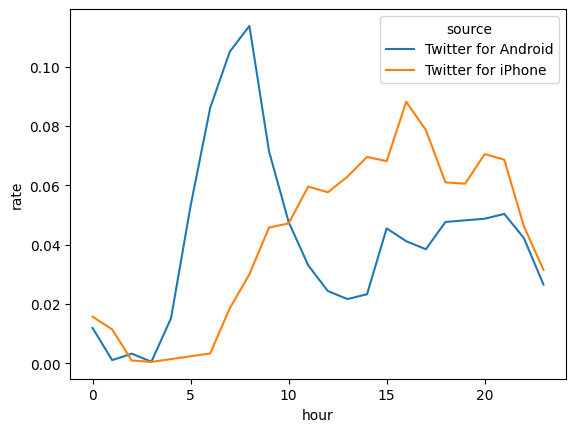

In [15]:
sns.lineplot(data=df_plot, x='hour', y='rate', hue='source')
plt.show()

In [16]:
#palabras comunes 

df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
Name: count, dtype: int64

In [17]:
stop_words = stopwords.words('english')

In [18]:
df['text'].apply(lambda x: remove_stopwords(x)).str.split(expand=True).stack().value_counts()[:10]

thank                     709
great                     610
-                         462
#trump2016                414
hillary                   352
&amp;                     316
new                       280
#makeamericagreatagain    260
people                    224
make                      218
Name: count, dtype: int64

In [19]:
df['text_clean'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_symbols(x))
df['text_clean'] = df['text_clean'].str.replace('-', '')
df['text_clean'] = df['text_clean'].str.replace('#', '')
df['text_clean'] = df['text_clean'].str.replace('https', '')
df['text_clean'] = df['text_clean'].str.replace('tco', '')
df['text_clean']

12072    would like wish everyone happy healthy new yea...
12073    believe state department new years eve release...
12074    thank illinois! lets forget get family amp; fr...
12075    happy birthday son @donaldjtrumpjr! proud you!...
12076    would feel sorry @jebbush badly campaign fact ...
                               ...                        
18502    well year officially begun many stops planned ...
18503    happy new year maralago! thank great family su...
18504                  happynewyearamerica! :///eeqb8pdrue
18505    happy new year amp; thank you! :///yo1yi8qbzy ...
18506    @foxnews live members family 11:50 pm ring new...
Name: text_clean, Length: 3946, dtype: object

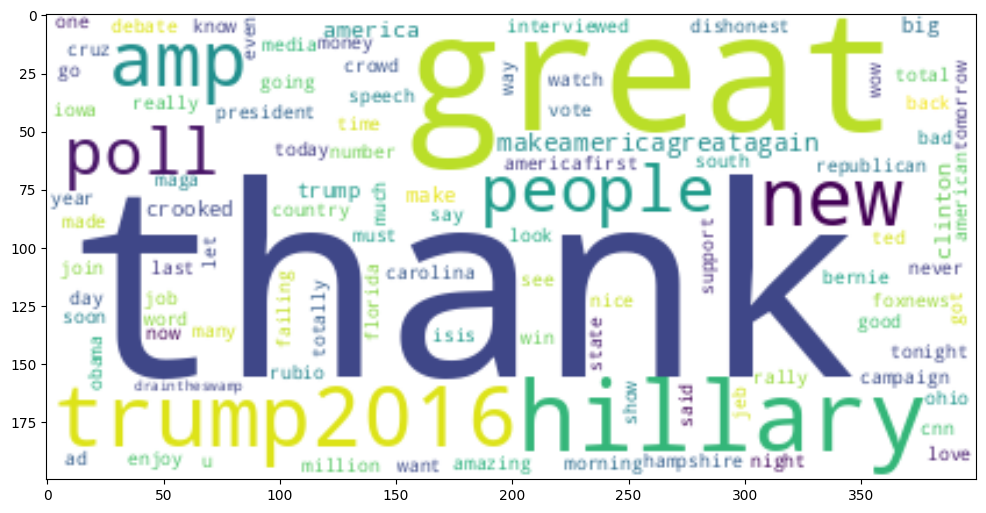

In [20]:
text = ' '.join(i for i in df.text_clean)
word_cloud = WordCloud(max_words=100, background_color='white', collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

In [23]:
# Bigrama coleccion de dos tonkens consecutivos 

word_cloud = WordCloud(collocation_threshold=2, collocations=True, max_words=100, background_color="White").generate(text)

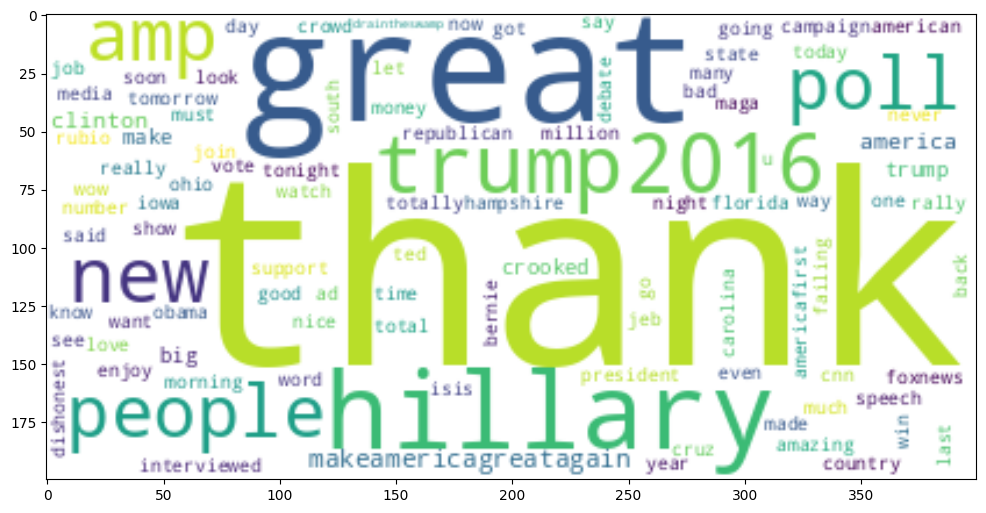

In [24]:
text = ' '.join(i for i in df.text_clean)
word_cloud = WordCloud(max_words=100, background_color='white', collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

In [27]:
# Determinar el sentimiento dependiendo del dispositivo 
df_word_split = (
    df
    .drop(["text", "created_at", "retweet_count", "favorite_count"], axis=1)
    .assign(text=df["text_clean"].str.split())
).explode("text").drop("text_clean",axis=1).rename(columns={"text":"word"})

In [28]:
df_word_split

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together!
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [30]:
df_word_split["word"].value_counts(normalize=True)

word
thank        0.016533
great        0.014574
trump2016    0.009654
hillary      0.009048
amp;         0.007369
               ...   
lafayette    0.000023
laredo       0.000023
11:50        0.000023
healthy      0.000023
lied!        0.000023
Name: proportion, Length: 9521, dtype: float64

In [35]:
(
df_word_split
.groupby(["source", "word"],observed=True)
.agg(count=("word", "count"))
.reset_index()
.merge(nrc[["word", "sentiment"]], on="word", how="inner")
.drop(["word","count"], axis=1)
["sentiment"].value_counts()
)

sentiment
positive        710
negative        656
trust           441
fear            338
sadness         320
anger           316
anticipation    281
joy             229
disgust         204
surprise        163
Name: count, dtype: int64

In [39]:
df_sent = (
    df_word_split
    .merge(nrc[["word", "sentiment"]], on="word", how="inner")
    .groupby(["source", "sentiment"], observed=False)
    .agg(count=("sentiment", "count"))
    .reset_index()
    .pivot_table(index=["sentiment"], columns=["source"], values="count", observed=False)
    .reset_index()
)
df_sent

source,sentiment,Twitter for Android,Twitter for iPhone
0,anger,871.0,467.0
1,anticipation,839.0,592.0
2,disgust,562.0,282.0
3,fear,755.0,441.0
4,joy,619.0,456.0
5,negative,1503.0,843.0
6,positive,1762.0,1388.0
7,sadness,826.0,464.0
8,surprise,524.0,352.0
9,trust,1228.0,903.0
